In [1]:
import numpy as np

# Load the .npy file
mask = np.load("/data_2/scratch/sbiegel/processed/forest_mask.npy")

print(type(mask))
print(mask.shape)
print(mask.dtype)



<class 'numpy.ndarray'>
(24542, 37728)
uint8


In [ ]:
24542 * 37728

925920576

In [18]:
print(mask[[0]])

[[0 0 0 ... 0 0 0]]


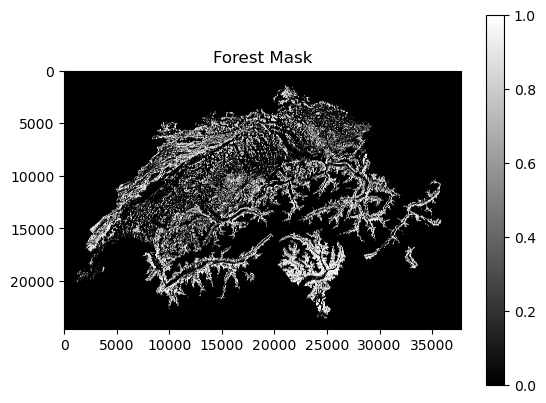

In [16]:
import matplotlib.pyplot as plt

plt.imshow(mask[0:37728], cmap="gray")
plt.colorbar()
plt.title("Forest Mask")
plt.show()


In [ ]:
bottom left = 2643297.187831 1133185.923649
bottom right = 2644291.031235 1133264.474717
upper rigth = 2644483.133362 1134544.573246
upper left = 2643586.030529 1134516.087231

In [20]:
import numpy as np

height, width = 24542, 37728
col_min, col_max = 16920, 17039
row_min, row_max =  6807,  6943

# build a mask or pull the linear indices
mask = np.zeros((height, width), dtype=bool)
mask[row_min:row_max+1, col_min:col_max+1] = True

rows = np.arange(row_min, row_max+1)[:, None]
cols = np.arange(col_min, col_max+1)[None, :]
row_idx = np.repeat(rows, cols.shape[1], axis=1)
col_idx = np.repeat(cols, rows.shape[0], axis=0)

# flattened row-major indices
flat_idx = (row_idx * width + col_idx).ravel()

print(flat_idx)


[256831416 256831417 256831418 ... 261962541 261962542 261962543]


In [24]:
# library loading
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import rioxarray
import zarr
import pandas as pd
from scipy.signal import savgol_filter





In [26]:
ndvi_path = "/data_2/scratch/sbiegel/processed/ndvi_dataset.zarr"
root = zarr.open(ndvi_path, mode='r', zarr_format=3)
ndvi_ds = root['ndvi']

In [27]:
print(ndvi_ds)

<Array file:///data_2/scratch/sbiegel/processed/ndvi_dataset.zarr/ndvi shape=(105715396, 1084) dtype=int16>


In [30]:
# Extract first timestep of the requested pixels
flat_idx_2 = flat_idx / 10

values = ndvi_ds[flat_idx_2.tolist(), 0]

# Convert flat indices to 2D indices
row_idx = flat_idx // width
col_idx = flat_idx % width

# Create empty raster
out_arr = np.full((height, width), -9999, dtype=z.dtype)
out_arr[row_idx, col_idx] = values


IndexError: unsupported selection item for basic indexing; expected integer or slice, got <class 'list'>

In [3]:
height* width

925920576

In [1]:
"""
Read first timestep (t=0) for an axis-aligned rectangle from a flattened Zarr NDVI dataset
and save a PNG of the cropped window.

Adjust zarr_path and out_png as needed.
"""
import numpy as np
import math
import os
import zarr
import matplotlib.pyplot as plt

# ----- CONFIG -----
zarr_path = "/data_2/scratch/sbiegel/processed/ndvi_dataset.zarr/ndvi"  # change if needed
height, width = 24542, 37728
left, bottom = 2474090.0, 1065110.0
px = 10.0

# Rectangle corners (UL and BR)
UL_x, UL_y = 2643586.030529, 1134516.087231
BR_x, BR_y = 2644291.031235, 1133264.474717

# output PNG
out_png = "/mnt/data/ndvi_rect_first_timestep.png"

# ----- compute pixel window -----
x_min = min(UL_x, BR_x)
x_max = max(UL_x, BR_x)
y_min = min(UL_y, BR_y)
y_max = max(UL_y, BR_y)

col_min = int(math.floor((x_min - left) / px))
col_max = int(math.floor((x_max - left) / px))
row_min = int(math.floor((y_min - bottom) / px))
row_max = int(math.floor((y_max - bottom) / px))

# clip
col_min = max(0, min(width-1, col_min))
col_max = max(0, min(width-1, col_max))
row_min = max(0, min(height-1, row_min))
row_max = max(0, min(height-1, row_max))

win_cols = col_max - col_min + 1
win_rows = row_max - row_min + 1

print(f"Pixel window cols {col_min}..{col_max} ({win_cols}), rows {row_min}..{row_max} ({win_rows})")

# ----- open Zarr -----
z = zarr.open(zarr_path, mode='r')  # expected shape (N, T)
N, T = z.shape
expected_N = height * width
if N != expected_N:
    raise RuntimeError(f"Zarr first dim {N} != expected raster size {expected_N}")

# build flat indices for window (row-major)
rows = np.arange(row_min, row_max+1, dtype=np.int64)
cols = np.arange(col_min, col_max+1, dtype=np.int64)
rr, cc = np.meshgrid(rows, cols, indexing='ij')   # shape (win_rows, win_cols)
flat_idx = (rr * width + cc).ravel()

# read values in batches (list indexing supported by zarr)
batch = 1_000_000
values = np.empty(flat_idx.shape[0], dtype=z.dtype)
start = 0
while start < flat_idx.shape[0]:
    end = min(start + batch, flat_idx.shape[0])
    sel = flat_idx[start:end].tolist()
    values[start:end] = z[sel, 0]   # first timestep
    start = end

window_arr = values.reshape((win_rows, win_cols))

# ----- plot and save PNG -----
# Convert to float for plotting. If nodata exists (e.g. -9999) mask it:
nodata = None
if np.issubdtype(window_arr.dtype, np.integer):
    # common nodata sentinel for int NDVI might be -9999; adjust if needed
    if (window_arr == -9999).any():
        nodata = -9999
        window_arr = window_arr.astype(float)
        window_arr[window_arr == nodata] = np.nan
    else:
        window_arr = window_arr.astype(float)

extent = (
    left + col_min * px,
    left + (col_max + 1) * px,
    bottom + row_min * px,
    bottom + (row_max + 1) * px
)

plt.figure(figsize=(8, 8 * win_rows / win_cols))
plt.imshow(window_arr, origin='lower', extent=extent)
plt.xlabel("EPSG:2056 X (m)")
plt.ylabel("EPSG:2056 Y (m)")
plt.title("First timestep (t=0) — cropped window")
c = plt.colorbar()
c.set_label("value (raw)")
plt.tight_layout()
plt.savefig(out_png, dpi=300)
plt.close()

print("Saved PNG:", out_png)


Pixel window cols 16949..17020 (72), rows 6815..6940 (126)


RuntimeError: Zarr first dim 105715396 != expected raster size 925920576

In [ ]:
"""
Read first timestep (t=0) from a forest-masked flattened Zarr NDVI array
for the axis-aligned rectangle (UL, BR), reconstruct the 2D window, and save a PNG.

Assumptions:
- mask file is /data_2/scratch/sbiegel/processed/forest_mask.npy
- mask shape == (24542, 37728) and ordering is row-major corresponding to the full raster extent
- zarr is at /data_2/scratch/sbiegel/processed/ndvi_dataset.zarr/ndvi with shape (n_masked_pixels, T)
- The order of masked pixels in the zarr matches np.flatnonzero(mask.ravel()) order
"""
import numpy as np
import math
import os
import zarr
import matplotlib.pyplot as plt

# ----- Config (change paths if needed) -----
zarr_path = "/data_2/scratch/sbiegel/processed/ndvi_dataset.zarr/ndvi"
mask_path = "/data_2/scratch/sbiegel/processed/forest_mask.npy"
out_png = "ndvi_rect_first_timestep_masked.png"

# Raster grid info
height, width = 24542, 37728
left, bottom = 2474090.0, 1065110.0
px = 10.0

# Rectangle corners (UL and BR)
UL_x, UL_y = 2644969.39, 1135151.86
BR_x, BR_y = 2645231.28, 1134845.30

# ----- compute axis-aligned pixel window -----
x_min = min(UL_x, BR_x)
x_max = max(UL_x, BR_x)
y_min = min(UL_y, BR_y)
y_max = max(UL_y, BR_y)

# convert UL/BR coordinates to row/col in the raster
col_min = int(math.floor((x_min - left) / px))
col_max = int(math.floor((x_max - left) / px))

# flip Y: top row = 0
row_min = int(math.floor((top - y_max) / px))   # top = 1310530.0
row_max = int(math.floor((top - y_min) / px))

# clip to raster bounds
col_min = max(0, min(width-1, col_min))
col_max = max(0, min(width-1, col_max))
row_min = max(0, min(height-1, row_min))
row_max = max(0, min(height-1, row_max))

win_cols = col_max - col_min + 1
win_rows = row_max - row_min + 1
print(f"Window cols {col_min}..{col_max} ({win_cols}), rows {row_min}..{row_max} ({win_rows})")

# ----- load mask and validate -----
mask = np.load(mask_path)  # expected shape (height, width)
if mask.shape != (height, width):
    raise RuntimeError(f"Mask shape {mask.shape} != expected {(height, width)}")

# flatten mask and compute mapping from full raster flat indices -> masked index (or -1)
mask_flat = mask.ravel(order='C')  # row-major
# idx_map: for each flattened full-pixel index i, idx_map[i] = position in masked array (0..n_masked-1), or -1 if not masked
masked_positions = np.flatnonzero(mask_flat)  # positions in full flat array where mask==True
n_masked = masked_positions.size
print(f"Mask has {n_masked} True pixels. Expect zarr first-dim == {n_masked}")

# build an array to map full flat index -> masked index (inverse mapping)
idx_map = np.full(mask_flat.shape[0], -1, dtype=np.int64)
idx_map[masked_positions] = np.arange(n_masked, dtype=np.int64)

# ----- compute flat indices for pixels inside the window (full raster indexing) -----
rows = np.arange(row_min, row_max+1, dtype=np.int64)
cols = np.arange(col_min, col_max+1, dtype=np.int64)
rr, cc = np.meshgrid(rows, cols, indexing='ij')   # shape (win_rows, win_cols)
full_flat_idx = (rr * width + cc).ravel()        # flattened indices in the full raster

# find which of those are masked
masked_idx_in_window = idx_map[full_flat_idx]    # gives masked index or -1
is_masked = masked_idx_in_window >= 0
n_masked_in_window = is_masked.sum()
print(f"Pixels in window: {full_flat_idx.size}, masked pixels in window: {n_masked_in_window}")

if n_masked_in_window == 0:
    print("No masked (forest) pixels inside the window. Creating empty PNG with NaNs.")
    window_arr = np.full((win_rows, win_cols), np.nan, dtype=float)
else:
    # ----- open zarr and validate shape -----
    z = zarr.open(zarr_path, mode='r')  # expected shape (n_masked, T)
    N, T = z.shape
    if N != n_masked:
        raise RuntimeError(f"Zarr first-dim {N} != mask True count {n_masked}. They must match.")

    # masked indices (positions in the zarr array) for pixels in the window
    zarr_indices_for_window = masked_idx_in_window[is_masked]  # length = n_masked_in_window

    # read zarr values in batches (list indexing)
    batch = 1_000_000
    values = np.empty(zarr_indices_for_window.shape[0], dtype=z.dtype)
    start = 0
    while start < zarr_indices_for_window.shape[0]:
        end = min(start + batch, zarr_indices_for_window.shape[0])
        sel = zarr_indices_for_window[start:end].tolist()
        values[start:end] = z[sel, 0]   # first timestep
        start = end

    # create window array and fill masked positions; others are NaN
    window_arr = np.full((win_rows * win_cols), np.nan, dtype=float)
    window_arr[is_masked] = values.astype(float)
    window_arr = window_arr.reshape((win_rows, win_cols))

# ----- plotting -----
extent = (
    left + col_min * px,
    left + (col_max + 1) * px,
    bottom + row_min * px,
    bottom + (row_max + 1) * px
)

plt.figure(figsize=(8, 8 * win_rows / win_cols))
im = plt.imshow(window_arr, origin='lower', extent=extent)
plt.xlabel("EPSG:2056 X (m)")
plt.ylabel("EPSG:2056 Y (m)")
plt.title("First timestep (t=0) — forest-masked window")
cbar = plt.colorbar(im)
cbar.set_label("value (raw)")
plt.tight_layout()
plt.savefig(out_png, dpi=300)
plt.close()
print("Saved PNG:", out_png)


Window cols 17087..17114 (28), rows 6973..7004 (32)
Mask has 105715396 True pixels. Expect zarr first-dim == 105715396
Pixels in window: 896, masked pixels in window: 738
Saved PNG: ndvi_rect_first_timestep_masked.png


In [ ]:
"""
Create a GIF of the first 500 timesteps from a forest-masked flattened Zarr NDVI array
for the axis-aligned rectangle (UL, BR), reconstruct the 2D window, and save as GIF.
"""

import numpy as np
import math
import zarr
import matplotlib.pyplot as plt
import imageio.v2 as imageio  # v2 API works like imread/imsave

# ----- Config (change paths if needed) -----
zarr_path = "/data_2/scratch/sbiegel/processed/ndvi_dataset.zarr/ndvi"
mask_path = "/data_2/scratch/sbiegel/processed/forest_mask.npy"
out_gif = "ndvi_rect_first500.gif"

# Raster grid info
height, width = 24542, 37728
left, bottom = 2474090.0, 1065110.0
px = 10.0

# Rectangle corners (UL and BR)
UL_x, UL_y = 2642528.529471, 1136393.505002
BR_x, BR_y = 2645348.532295, 1131387.055946

# ----- compute axis-aligned pixel window -----
x_min = min(UL_x, BR_x)
x_max = max(UL_x, BR_x)
y_min = min(UL_y, BR_y)
y_max = max(UL_y, BR_y)

col_min = int(math.floor((x_min - left) / px))
col_max = int(math.floor((x_max - left) / px))
row_min = int(math.floor((y_min - bottom) / px))
row_max = int(math.floor((y_max - bottom) / px))

# clip to raster bounds
col_min = max(0, min(width-1, col_min))
col_max = max(0, min(width-1, col_max))
row_min = max(0, min(height-1, row_min))
row_max = max(0, min(height-1, row_max))

win_cols = col_max - col_min + 1
win_rows = row_max - row_min + 1
print(f"Window cols {col_min}..{col_max} ({win_cols}), rows {row_min}..{row_max} ({win_rows})")

# ----- load mask and validate -----
mask = np.load(mask_path)
assert mask.shape == (height, width)

mask_flat = mask.ravel(order="C")
masked_positions = np.flatnonzero(mask_flat)
n_masked = masked_positions.size
print(f"Mask has {n_masked} True pixels.")

# build full index -> masked index map
idx_map = np.full(mask_flat.shape[0], -1, dtype=np.int64)
idx_map[masked_positions] = np.arange(n_masked, dtype=np.int64)

# ----- indices inside window -----
rows = np.arange(row_min, row_max+1, dtype=np.int64)
cols = np.arange(col_min, col_max+1, dtype=np.int64)
rr, cc = np.meshgrid(rows, cols, indexing="ij")
full_flat_idx = (rr * width + cc).ravel()

masked_idx_in_window = idx_map[full_flat_idx]
is_masked = masked_idx_in_window >= 0
n_masked_in_window = is_masked.sum()
print(f"Pixels in window: {full_flat_idx.size}, masked pixels: {n_masked_in_window}")

if n_masked_in_window == 0:
    raise RuntimeError("No masked (forest) pixels inside the window.")

# ----- open zarr -----
z = zarr.open(zarr_path, mode="r")  # shape (n_masked, T)
N, T = z.shape
assert N == n_masked, f"Zarr first-dim {N} != mask True count {n_masked}"

# which timesteps?
n_frames = min(50, T)

# window extent
extent = (
    left + col_min * px,
    left + (col_max + 1) * px,
    bottom + row_min * px,
    bottom + (row_max + 1) * px,
)

# ----- create GIF -----
frames = []
for t in range(n_frames):
    print(f"Frame {t+1}/{n_frames}")
    # read values for this timestep
    batch = 1_000_000
    values = np.empty(n_masked_in_window, dtype=z.dtype)
    start = 0
    while start < n_masked_in_window:
        end = min(start + batch, n_masked_in_window)
        sel = masked_idx_in_window[is_masked][start:end].tolist()
        values[start:end] = z[sel, t]
        start = end

    window_arr = np.full((win_rows * win_cols), np.nan, dtype=float)
    window_arr[is_masked] = values.astype(float)
    window_arr = window_arr.reshape((win_rows, win_cols))

    # plot to image buffer
    fig, ax = plt.subplots(figsize=(6, 6 * win_rows / win_cols))
    im = ax.imshow(window_arr, origin="lower", extent=extent,
                   vmin=-10000, vmax=10000, cmap="RdYlGn")
    ax.set_title(f"NDVI timestep {t}")
    ax.set_xlabel("EPSG:2056 X (m)")
    ax.set_ylabel("EPSG:2056 Y (m)")
    plt.colorbar(im, ax=ax, label="value (raw)")

    # draw and convert to numpy
    fig.canvas.draw()
    buf = np.asarray(fig.canvas.buffer_rgba())  # returns HxWx4 (RGBA)
    image = buf[:, :, :3].copy()  # drop alpha channel
    frames.append(image)
    plt.close(fig)
    
# save GIF
imageio.mimsave(out_gif, frames, fps=10)  # ~50 sec for 500 frames
print("Saved GIF:", out_gif)


Window cols 16843..17125 (283), rows 6627..7128 (502)


Mask has 105715396 True pixels.
Pixels in window: 142066, masked pixels: 45870
Frame 1/500
Frame 2/500
Frame 3/500
Frame 4/500
Frame 5/500
Frame 6/500
Frame 7/500
Frame 8/500
Frame 9/500
Frame 10/500
Frame 11/500
Frame 12/500
Frame 13/500
Frame 14/500
Frame 15/500
Frame 16/500
Frame 17/500
Frame 18/500
Frame 19/500
Frame 20/500
Frame 21/500
Frame 22/500
Frame 23/500
Frame 24/500
Frame 25/500
Frame 26/500
Frame 27/500
Frame 28/500
Frame 29/500
Frame 30/500
Frame 31/500
Frame 32/500
Frame 33/500
Frame 34/500
Frame 35/500
Frame 36/500
Frame 37/500
Frame 38/500
Frame 39/500
Frame 40/500
Frame 41/500
Frame 42/500
Frame 43/500
Frame 44/500
Frame 45/500
Frame 46/500
Frame 47/500
Frame 48/500
Frame 49/500
Frame 50/500
Frame 51/500
Frame 52/500
Frame 53/500
Frame 54/500
Frame 55/500
Frame 56/500
Frame 57/500
Frame 58/500
Frame 59/500
Frame 60/500
Frame 61/500
Frame 62/500
Frame 63/500
Frame 64/500
Frame 65/500
Frame 66/500
Frame 67/500
Frame 68/500
Frame 69/500
Frame 70/500
Frame 71/500
Frame 7

Window cols 16879..17090 (212), rows 17602..17851 (250)


Mask has 105715396 True pixels.
Pixels in window: 53000, masked pixels: 26886


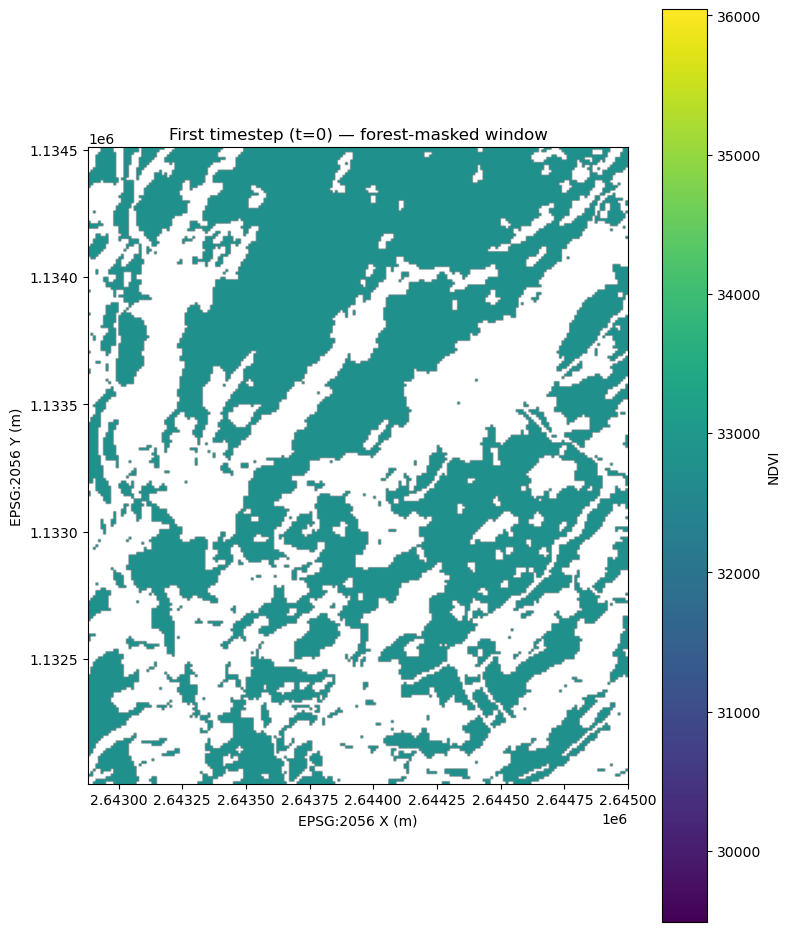

Saved PNG: ndvi_rect_first_timestep_masked.png


In [12]:
import numpy as np
import math
import zarr
import matplotlib.pyplot as plt

# ----- Config -----
zarr_path = "/data_2/scratch/sbiegel/processed/ndvi_dataset.zarr/ndvi"
mask_path = "/data_2/scratch/sbiegel/processed/forest_mask.npy"
out_png = "ndvi_rect_first_timestep_masked.png"

# Raster info
height, width = 24542, 37728
left, bottom = 2474090.0, 1065110.0
top = bottom + height * 10.0
px = 10.0

# Rectangle corners (UL, BR)
#UL_x, UL_y = 2643586.030529, 1134516.087231
#BR_x, BR_y = 2644291.031235, 1133264.474717

UL_x, UL_y = 2642881.029823, 1134500.699745
BR_x, BR_y = 2644996.031941, 1132012.862203


# ----- compute pixel window -----
x_min, x_max = min(UL_x, BR_x), max(UL_x, BR_x)
y_min, y_max = min(UL_y, BR_y), max(UL_y, BR_y)

col_min = int(math.floor((x_min - left) / px))
col_max = int(math.floor((x_max - left) / px))

# row 0 = top
row_min = int(math.floor((top - y_max) / px))
row_max = int(math.floor((top - y_min) / px))

# clip to bounds
col_min = max(0, min(width-1, col_min))
col_max = max(0, min(width-1, col_max))
row_min = max(0, min(height-1, row_min))
row_max = max(0, min(height-1, row_max))

win_cols = col_max - col_min + 1
win_rows = row_max - row_min + 1
print(f"Window cols {col_min}..{col_max} ({win_cols}), rows {row_min}..{row_max} ({win_rows})")

# ----- load mask -----
mask = np.load(mask_path)
if mask.shape != (height, width):
    raise RuntimeError(f"Mask shape {mask.shape} != expected {(height, width)}")

mask_flat = mask.ravel(order='C')
masked_positions = np.flatnonzero(mask_flat)
n_masked = masked_positions.size
print(f"Mask has {n_masked} True pixels.")

idx_map = np.full(mask_flat.shape[0], -1, dtype=np.int64)
idx_map[masked_positions] = np.arange(n_masked, dtype=np.int64)

# ----- compute flat indices in window -----
rows = np.arange(row_min, row_max+1, dtype=np.int64)
cols = np.arange(col_min, col_max+1, dtype=np.int64)
rr, cc = np.meshgrid(rows, cols, indexing='ij')
full_flat_idx = (rr * width + cc).ravel()

masked_idx_in_window = idx_map[full_flat_idx]
is_masked = masked_idx_in_window >= 0
n_masked_in_window = is_masked.sum()
print(f"Pixels in window: {full_flat_idx.size}, masked pixels: {n_masked_in_window}")

if n_masked_in_window == 0:
    window_arr = np.full((win_rows, win_cols), np.nan, dtype=float)
else:
    # ----- open Zarr -----
    z = zarr.open(zarr_path, mode='r')
    N, T = z.shape
    if N != n_masked:
        raise RuntimeError(f"Zarr first-dim {N} != mask True count {n_masked}.")

    zarr_indices_for_window = masked_idx_in_window[is_masked]

    # read first timestep
    values = np.empty(zarr_indices_for_window.shape[0], dtype=z.dtype)
    batch = 1_000_000
    start = 0
    while start < zarr_indices_for_window.shape[0]:
        end = min(start + batch, zarr_indices_for_window.shape[0])
        sel = zarr_indices_for_window[start:end].tolist()
        values[start:end] = z[sel, 0]  # first timestep
        start = end

    # reconstruct 2D window
    window_arr = np.full((win_rows * win_cols), np.nan, dtype=float)
    window_arr[is_masked] = values.astype(float)
    window_arr = window_arr.reshape((win_rows, win_cols))

# ----- plotting -----
extent = (
    left + col_min * px,
    left + (col_max + 1) * px,
    top - (row_max + 1) * px,
    top - row_min * px
)

plt.figure(figsize=(8, 8 * win_rows / win_cols))
im = plt.imshow(window_arr, origin='upper', extent=extent)
plt.xlabel("EPSG:2056 X (m)")
plt.ylabel("EPSG:2056 Y (m)")
plt.title("First timestep (t=0) — forest-masked window")
cbar = plt.colorbar(im)
cbar.set_label("NDVI")
plt.tight_layout()
plt.savefig(out_png, dpi=300)
plt.show()
plt.close()
print("Saved PNG:", out_png)


In [2]:
import numpy as np
import math
import zarr
import matplotlib.pyplot as plt
import imageio.v2 as imageio

# ----- Config -----
zarr_path = "/data_2/scratch/sbiegel/processed/ndvi_dataset.zarr/ndvi"
mask_path = "/data_2/scratch/sbiegel/processed/forest_mask.npy"
out_png = "ndvi_rect_first_timestep_masked.png"

# Raster info
height, width = 24542, 37728
left, bottom = 2474090.0, 1065110.0
top = bottom + height * 10.0
px = 10.0

# Rectangle corners (UL, BR)
#UL_x, UL_y = 2643586.030529, 1134516.087231
#BR_x, BR_y = 2644291.031235, 1133264.474717

UL_x, UL_y = 2642881.029823, 1134500.699745
BR_x, BR_y = 2644996.031941, 1132012.862203


# ----- compute pixel window -----
x_min, x_max = min(UL_x, BR_x), max(UL_x, BR_x)
y_min, y_max = min(UL_y, BR_y), max(UL_y, BR_y)

col_min = int(math.floor((x_min - left) / px))
col_max = int(math.floor((x_max - left) / px))

# row 0 = top
row_min = int(math.floor((top - y_max) / px))
row_max = int(math.floor((top - y_min) / px))

# clip to bounds
col_min = max(0, min(width-1, col_min))
col_max = max(0, min(width-1, col_max))
row_min = max(0, min(height-1, row_min))
row_max = max(0, min(height-1, row_max))

win_cols = col_max - col_min + 1
win_rows = row_max - row_min + 1
print(f"Window cols {col_min}..{col_max} ({win_cols}), rows {row_min}..{row_max} ({win_rows})")

# ----- load mask -----
mask = np.load(mask_path)
if mask.shape != (height, width):
    raise RuntimeError(f"Mask shape {mask.shape} != expected {(height, width)}")

mask_flat = mask.ravel(order='C')
masked_positions = np.flatnonzero(mask_flat)
n_masked = masked_positions.size
print(f"Mask has {n_masked} True pixels.")

idx_map = np.full(mask_flat.shape[0], -1, dtype=np.int64)
idx_map[masked_positions] = np.arange(n_masked, dtype=np.int64)

# ----- compute flat indices in window -----
rows = np.arange(row_min, row_max+1, dtype=np.int64)
cols = np.arange(col_min, col_max+1, dtype=np.int64)
rr, cc = np.meshgrid(rows, cols, indexing='ij')
full_flat_idx = (rr * width + cc).ravel()

masked_idx_in_window = idx_map[full_flat_idx]
is_masked = masked_idx_in_window >= 0
n_masked_in_window = is_masked.sum()
print(f"Pixels in window: {full_flat_idx.size}, masked pixels: {n_masked_in_window}")

if n_masked_in_window == 0:
    window_arr = np.full((win_rows, win_cols), np.nan, dtype=float)
else:
    # ----- open Zarr -----
    z = zarr.open(zarr_path, mode='r')
    N, T = z.shape
    if N != n_masked:
        raise RuntimeError(f"Zarr first-dim {N} != mask True count {n_masked}.")

    zarr_indices_for_window = masked_idx_in_window[is_masked]

    # read first timestep
    values = np.empty(zarr_indices_for_window.shape[0], dtype=z.dtype)
    batch = 1_000_000
    start = 0
    while start < zarr_indices_for_window.shape[0]:
        end = min(start + batch, zarr_indices_for_window.shape[0])
        sel = zarr_indices_for_window[start:end].tolist()
        values[start:end] = z[sel, 0]  # first timestep
        start = end

    # reconstruct 2D window
    window_arr = np.full((win_rows * win_cols), np.nan, dtype=float)
    window_arr[is_masked] = values.astype(float)
    window_arr = window_arr.reshape((win_rows, win_cols))

# ----- plotting extent -----
extent = (
    left + col_min * px,
    left + (col_max + 1) * px,
    top - (row_max + 1) * px,
    top - row_min * px
)
n_frames = 10

frames = []

for t in range(n_frames):
    # ----- read masked NDVI values for this timestep -----
    batch = 1_000_000
    values = np.empty(n_masked_in_window, dtype=float)
    start = 0
    while start < n_masked_in_window:
        end = min(start + batch, n_masked_in_window)
        sel = masked_idx_in_window[is_masked][start:end].tolist()
        values_batch = z[sel, t].astype(float)

        # normalize
        values_batch /= 10000.0

        # mask clouds
        values_batch = np.where((values_batch > 1) | (values_batch < 0), np.nan, values_batch)

        values[start:end] = values_batch
        start = end

    # reconstruct 2D window
    window_arr = np.full((win_rows * win_cols), np.nan, dtype=float)
    window_arr[is_masked] = values
    window_arr = window_arr.reshape((win_rows, win_cols))

    # ----- plot frame -----
    fig, ax = plt.subplots(figsize=(6, 6 * win_rows / win_cols))
    im = ax.imshow(window_arr, origin='upper', extent=extent,
                   vmin=0, vmax=1, cmap="RdYlGn")  # normalized NDVI
    ax.set_title(f"NDVI step {t}")
    ax.set_xlabel("EPSG:2056 (m)")
    ax.set_ylabel("EPSG:2056 (m)")
    plt.colorbar(im, ax=ax, label="NDVI")

    # convert to image
    fig.canvas.draw()
    buf = np.asarray(fig.canvas.buffer_rgba())
    image = buf[:, :, :3].copy()
    frames.append(image)
    plt.close(fig)

# save GIF
imageio.mimsave(out_gif, frames, fps=10)
print("Saved GIF:", out_gif)


Window cols 16879..17090 (212), rows 17602..17851 (250)


Mask has 105715396 True pixels.
Pixels in window: 53000, masked pixels: 26886


NameError: name 'out_gif' is not defined

In [ ]:
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np

# ----- plotting extent -----
extent = (
    left + col_min * px,
    left + (col_max + 1) * px,
    top - (row_max + 1) * px,
    top - row_min * px
)
n_frames = 100

frames = []

for t in range(n_frames):
    # ----- read masked NDVI values for this timestep -----
    batch = 1_000_000
    values = np.empty(n_masked_in_window, dtype=float)
    start = 0
    while start < n_masked_in_window:
        end = min(start + batch, n_masked_in_window)
        sel = masked_idx_in_window[is_masked][start:end].tolist()
        values_batch = z[sel, t].astype(float)

        # normalize
        values_batch /= 10000.0

        # mask clouds
        values_batch = np.where((values_batch > 1) | (values_batch < 0), np.nan, values_batch)

        values[start:end] = values_batch
        start = end

    # reconstruct 2D window
    window_arr = np.full((win_rows * win_cols), np.nan, dtype=float)
    window_arr[is_masked] = values
    window_arr = window_arr.reshape((win_rows, win_cols))

    # ----- plot frame -----
    fig, ax = plt.subplots(figsize=(6, 6 * win_rows / win_cols))
    im = ax.imshow(window_arr, origin='upper', extent=extent,
                   vmin=0, vmax=1, cmap="RdYlGn")  # normalized NDVI
    ax.set_title(f"NDVI step {t}")
    ax.set_xlabel("EPSG:2056 (m)")
    ax.set_ylabel("EPSG:2056 (m)")
    plt.colorbar(im, ax=ax, label="NDVI")

    # convert to image
    fig.canvas.draw()
    buf = np.asarray(fig.canvas.buffer_rgba())
    image = buf[:, :, :3].copy()
    frames.append(image)
    plt.close(fig)

# save GIF
imageio.mimsave(out_gif, frames, fps=10)
print("Saved GIF:", out_gif)


Saved GIF: ndvi_rect_first500.gif


In [4]:
import numpy as np
import math
import zarr
import matplotlib.pyplot as plt
import imageio.v2 as imageio

# ----- Config -----
zarr_path = "/data_2/scratch/sbiegel/processed/ndvi_dataset.zarr/ndvi"
mask_path = "/data_2/scratch/sbiegel/processed/forest_mask.npy"
out_gif = "ndvi_rect_first500.gif"

# Raster info
height, width = 24542, 37728
left, bottom = 2474090.0, 1065110.0
px = 10.0
top = bottom + height * px

# Rectangle corners (UL and BR)
UL_x, UL_y = 2642881.029823, 1134500.699745
BR_x, BR_y = 2644996.031941, 1132012.862203

# ----- compute pixel window (row 0 = top) -----
x_min, x_max = min(UL_x, BR_x), max(UL_x, BR_x)
y_min, y_max = min(UL_y, BR_y), max(UL_y, BR_y)

col_min = int(math.floor((x_min - left) / px))
col_max = int(math.floor((x_max - left) / px))

row_min = int(math.floor((top - y_max) / px))
row_max = int(math.floor((top - y_min) / px))

# clip to bounds
col_min = max(0, min(width-1, col_min))
col_max = max(0, min(width-1, col_max))
row_min = max(0, min(height-1, row_min))
row_max = max(0, min(height-1, row_max))

win_cols = col_max - col_min + 1
win_rows = row_max - row_min + 1
print(f"Window cols {col_min}..{col_max} ({win_cols}), rows {row_min}..{row_max} ({win_rows})")

# ----- load mask -----
mask = np.load(mask_path)
assert mask.shape == (height, width), f"Mask shape {mask.shape} != raster {(height, width)}"

mask_flat = mask.ravel(order='C')
masked_positions = np.flatnonzero(mask_flat)
n_masked = masked_positions.size
print(f"Mask has {n_masked} True pixels.")

# build index map from full array -> masked array
idx_map = np.full(mask_flat.shape[0], -1, dtype=np.int64)
idx_map[masked_positions] = np.arange(n_masked, dtype=np.int64)

# ----- compute flat indices in window -----
rows = np.arange(row_min, row_max+1, dtype=np.int64)
cols = np.arange(col_min, col_max+1, dtype=np.int64)
rr, cc = np.meshgrid(rows, cols, indexing='ij')
full_flat_idx = (rr * width + cc).ravel()

masked_idx_in_window = idx_map[full_flat_idx]
is_masked = masked_idx_in_window >= 0
n_masked_in_window = is_masked.sum()
print(f"Pixels in window: {full_flat_idx.size}, masked pixels: {n_masked_in_window}")

if n_masked_in_window == 0:
    raise RuntimeError("No masked pixels in window!")

# ----- open Zarr -----
z = zarr.open(zarr_path, mode='r')
N, T = z.shape
assert N == n_masked, f"Zarr first-dim {N} != mask True count {n_masked}"

# Limit to first 500 timesteps or all
n_frames = min(5000, T)

# ----- plotting extent -----
extent = (
    left + col_min * px,
    left + (col_max + 1) * px,
    top - (row_max + 1) * px,
    top - row_min * px
)

# ----- create GIF -----
frames = []

for t in range(n_frames):
    # read NDVI for masked pixels in window
    values = np.empty(n_masked_in_window, dtype=float)
    batch = 1_000_000
    start = 0
    while start < n_masked_in_window:
        end = min(start + batch, n_masked_in_window)
        sel = masked_idx_in_window[is_masked][start:end].tolist()
        values_batch = z[sel, t].astype(float)

        # normalize
        values_batch /= 10000.0

        # mask clouds
        values_batch = np.where((values_batch > 1) | (values_batch < 0), np.nan, values_batch)

        values[start:end] = values_batch
        start = end

    # reconstruct 2D window
    window_arr = np.full(win_rows * win_cols, np.nan, dtype=float)
    window_arr[is_masked] = values
    window_arr = window_arr.reshape((win_rows, win_cols))

    # plot frame
    fig, ax = plt.subplots(figsize=(6, 6 * win_rows / win_cols))
    im = ax.imshow(window_arr, origin='upper', extent=extent, vmin=0, vmax=1, cmap="RdYlGn")
    ax.set_title(f"NDVI timestep {t}")
    ax.set_xlabel("EPSG:2056 (m)")
    ax.set_ylabel("EPSG:2056 (m)")
    plt.colorbar(im, ax=ax, label="NDVI")

    # convert to image
    fig.canvas.draw()
    buf = np.asarray(fig.canvas.buffer_rgba())
    image = buf[:, :, :3].copy()
    frames.append(image)
    plt.close(fig)

# save GIF
imageio.mimsave(out_gif, frames, fps=10)
print("Saved GIF:", out_gif)


Window cols 16879..17090 (212), rows 17602..17851 (250)
Mask has 105715396 True pixels.
Pixels in window: 53000, masked pixels: 26886


KeyboardInterrupt: 

In [7]:
import numpy as np
import math
import zarr
import matplotlib.pyplot as plt
import imageio.v2 as imageio

# ----- Config -----
zarr_path = "/data_2/scratch/sbiegel/processed/ndvi_dataset.zarr/ndvi"
mask_path = "/data_2/scratch/sbiegel/processed/forest_mask.npy"
out_gif = "ndvi_rect_first500.gif"

# Raster info
height, width = 24542, 37728
left, bottom = 2474090.0, 1065110.0
px = 10.0
top = bottom + height * px

# Rectangle corners (UL and BR)
UL_x, UL_y = 2642881.029823, 1134500.699745
BR_x, BR_y = 2644996.031941, 1132012.862203

# ----- compute pixel window (row 0 = top) -----
x_min, x_max = min(UL_x, BR_x), max(UL_x, BR_x)
y_min, y_max = min(UL_y, BR_y), max(UL_y, BR_y)

col_min = int(math.floor((x_min - left) / px))
col_max = int(math.floor((x_max - left) / px))

row_min = int(math.floor((top - y_max) / px))
row_max = int(math.floor((top - y_min) / px))

# clip to bounds
col_min = max(0, min(width-1, col_min))
col_max = max(0, min(width-1, col_max))
row_min = max(0, min(height-1, row_min))
row_max = max(0, min(height-1, row_max))

win_cols = col_max - col_min + 1
win_rows = row_max - row_min + 1
print(f"Window cols {col_min}..{col_max} ({win_cols}), rows {row_min}..{row_max} ({win_rows})")

# ----- load mask -----
mask = np.load(mask_path)
assert mask.shape == (height, width), f"Mask shape {mask.shape} != raster {(height, width)}"

mask_flat = mask.ravel(order='C')
masked_positions = np.flatnonzero(mask_flat)
n_masked = masked_positions.size
print(f"Mask has {n_masked} True pixels.")

# build index map from full array -> masked array
idx_map = np.full(mask_flat.shape[0], -1, dtype=np.int64)
idx_map[masked_positions] = np.arange(n_masked, dtype=np.int64)

# ----- compute flat indices in window -----
rows = np.arange(row_min, row_max+1, dtype=np.int64)
cols = np.arange(col_min, col_max+1, dtype=np.int64)
rr, cc = np.meshgrid(rows, cols, indexing='ij')
full_flat_idx = (rr * width + cc).ravel()

masked_idx_in_window = idx_map[full_flat_idx]
is_masked = masked_idx_in_window >= 0
n_masked_in_window = is_masked.sum()
print(f"Pixels in window: {full_flat_idx.size}, masked pixels: {n_masked_in_window}")

if n_masked_in_window == 0:
    raise RuntimeError("No masked pixels in window!")

# ----- open Zarr -----
z = zarr.open(zarr_path, mode='r')
N, T = z.shape
assert N == n_masked, f"Zarr first-dim {N} != mask True count {n_masked}"

# Limit to first 500 timesteps or all
n_frames = min(5000, T)

# ----- plotting extent -----
extent = (
    left + col_min * px,
    left + (col_max + 1) * px,
    top - (row_max + 1) * px,
    top - row_min * px
)

# ----- create GIF -----
frames = []

for t in np.arange(900,n_frames):
    # read NDVI for masked pixels in window
    values = np.empty(n_masked_in_window, dtype=float)
    batch = 1_000_000
    start = 0
    while start < n_masked_in_window:
        end = min(start + batch, n_masked_in_window)
        sel = masked_idx_in_window[is_masked][start:end].tolist()
        values_batch = z[sel, t].astype(float)

        # normalize
        values_batch /= 10000.0

        # mask clouds
        values_batch = np.where((values_batch > 1) | (values_batch < 0), np.nan, values_batch)

        values[start:end] = values_batch
        start = end

    # reconstruct 2D window
    window_arr = np.full(win_rows * win_cols, np.nan, dtype=float)
    window_arr[is_masked] = values
    window_arr = window_arr.reshape((win_rows, win_cols))

    # plot frame
    fig, ax = plt.subplots(figsize=(6, 6 * win_rows / win_cols))
    im = ax.imshow(window_arr, origin='upper', extent=extent, vmin=0, vmax=1, cmap="RdYlGn")
    ax.set_title(f"NDVI timestep {t}")
    ax.set_xlabel("EPSG:2056 (m)")
    ax.set_ylabel("EPSG:2056 (m)")
    plt.colorbar(im, ax=ax, label="NDVI")

    # convert to image
    fig.canvas.draw()
    buf = np.asarray(fig.canvas.buffer_rgba())
    image = buf[:, :, :3].copy()
    frames.append(image)
    plt.close(fig)

# save GIF
imageio.mimsave(out_gif, frames, fps=10)
print("Saved GIF:", out_gif)


Window cols 16879..17090 (212), rows 17602..17851 (250)
Mask has 105715396 True pixels.
Pixels in window: 53000, masked pixels: 26886
Saved GIF: ndvi_rect_first500.gif
